In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import io, s3fs, json
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-05-24 11:58:54.528527


In [2]:
est = pd.read_csv('s3://bleeding-hearts/workingdata/merge_est.csv')
est.head()

,Unnamed: 0,EMPLOYMENT STATUS_Population 16 years and over,EMPLOYMENT STATUS_Population 16 years and over_In labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces,EMPLOYMENT STATUS_Population 16 years and over_Not in labor force,EMPLOYMENT STATUS_Civilian labor force,EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate,EMPLOYMENT STATUS_Females 16 years and over,EMPLOYMENT STATUS_Females 16 years and over_In labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Own children of the householder under 6 years,EMPLOYMENT STATUS_Own children of the householder under 6 years_All parents in family in labor force,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years_All parents in family in labor force,COMMUTING TO WORK_Workers 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone","COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- carpooled",COMMUTING TO WORK_Workers 16 years and over_Public transportation (excluding taxicab),COMMUTING TO WORK_Workers 16 years and over_Walked,COMMUTING TO WORK_Workers 16 years and over_Other means,COMMUTING TO WORK_Workers 16 years and over_Worked at home,COMMUTING TO WORK_Mean travel time to work (minutes),OCCUPATION_Civilian employed population 16 years and over,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",OCCUPATION_Civilian employed population 16 years and over_Service occupations,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations","OCCUPATION_Civilian employed population 16 years and over_Production, transportation, and material moving occupations",INDUSTRY_Civilian employed population 16 years and over,"INDUSTRY_Civilian employed population 16 years and over_Agriculture, forestry, fishing and hunting, and mining",INDUSTRY_Civilian employed population 16 years and over_Construction,INDUSTRY_Civilian employed population 16 years and over_Manufacturing,INDUSTRY_Civilian employed population 16 years and over_Wholesale trade,INDUSTRY_Civilian employed population 16 years and over_Retail trade,"INDUSTRY_Civilian employed population 16 years and over_Transportation and warehousing, and utilities",INDUSTRY_Civilian employed population 16 years and over_Information,"INDUSTRY_Civilian employed population 16 years and over_Finance and insurance, and real estate and rental and leasing","INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","INDUSTRY_Civilian employed population 16 years and over_Educational services, and health care and social assistance","INDUSTRY_Civilian employed population 16 years and over_Arts, entertainment, and recreation, and accommodation and food services","INDUSTRY_Civilian employed population 16 years and over_Other services, except public administration",INDUSTRY_Civilian employed population 16 years and over_Public administration,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,CLASS OF WORKER_Civilian employed population 16 years and over_Government workers,CLASS OF WORKER_Civilian employed population 16 years and over_Self-employed in own not incorporated business workers,CLASS OF W

In [3]:
est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18897 entries, 0 to 18896
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(1), int64(143), object(4)
memory usage: 21.3+ MB


In [4]:
pct = pd.read_csv('s3://bleeding-hearts/workingdata/merge_pct.csv')
pct.head()

,Unnamed: 0,EMPLOYMENT STATUS_Population 16 years and over,EMPLOYMENT STATUS_Population 16 years and over_In labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces,EMPLOYMENT STATUS_Population 16 years and over_Not in labor force,EMPLOYMENT STATUS_Civilian labor force,EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate,EMPLOYMENT STATUS_Females 16 years and over,EMPLOYMENT STATUS_Females 16 years and over_In labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Own children of the householder under 6 years,EMPLOYMENT STATUS_Own children of the householder under 6 years_All parents in family in labor force,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years_All parents in family in labor force,COMMUTING TO WORK_Workers 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone","COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- carpooled",COMMUTING TO WORK_Workers 16 years and over_Public transportation (excluding taxicab),COMMUTING TO WORK_Workers 16 years and over_Walked,COMMUTING TO WORK_Workers 16 years and over_Other means,COMMUTING TO WORK_Workers 16 years and over_Worked at home,COMMUTING TO WORK_Mean travel time to work (minutes),OCCUPATION_Civilian employed population 16 years and over,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",OCCUPATION_Civilian employed population 16 years and over_Service occupations,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations","OCCUPATION_Civilian employed population 16 years and over_Production, transportation, and material moving occupations",INDUSTRY_Civilian employed population 16 years and over,"INDUSTRY_Civilian employed population 16 years and over_Agriculture, forestry, fishing and hunting, and mining",INDUSTRY_Civilian employed population 16 years and over_Construction,INDUSTRY_Civilian employed population 16 years and over_Manufacturing,INDUSTRY_Civilian employed population 16 years and over_Wholesale trade,INDUSTRY_Civilian employed population 16 years and over_Retail trade,"INDUSTRY_Civilian employed population 16 years and over_Transportation and warehousing, and utilities",INDUSTRY_Civilian employed population 16 years and over_Information,"INDUSTRY_Civilian employed population 16 years and over_Finance and insurance, and real estate and rental and leasing","INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","INDUSTRY_Civilian employed population 16 years and over_Educational services, and health care and social assistance","INDUSTRY_Civilian employed population 16 years and over_Arts, entertainment, and recreation, and accommodation and food services","INDUSTRY_Civilian employed population 16 years and over_Other services, except public administration",INDUSTRY_Civilian employed population 16 years and over_Public administration,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,CLASS OF WORKER_Civilian employed population 16 years and over_Government workers,CLASS OF WORKER_Civilian employed population 16 years and over_Self-employed in own not incorporated business workers,CLASS OF W

In [5]:
pct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18897 entries, 0 to 18896
Columns: 148 entries, Unnamed: 0 to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(102), int64(42), object(4)
memory usage: 21.3+ MB


In [12]:
for i in [est,pct]:
    i.drop(columns=['Unnamed: 0','year','FIPS'],inplace=True)
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18897 entries, 0 to 18896
Columns: 145 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(1), int64(140), object(4)
memory usage: 20.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18897 entries, 0 to 18896
Columns: 145 entries, EMPLOYMENT STATUS_Population 16 years and over to Child Opportunity Scores, overall COI, nationally-normed
dtypes: float64(102), int64(39), object(4)
memory usage: 20.9+ MB
None


In [8]:
from pandas import plotting
import matplotlib.pyplot as plt

# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

#Model toolset
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

In [13]:
est.head()

,EMPLOYMENT STATUS_Population 16 years and over,EMPLOYMENT STATUS_Population 16 years and over_In labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Civilian labor force_Unemployed,EMPLOYMENT STATUS_Population 16 years and over_In labor force_Armed Forces,EMPLOYMENT STATUS_Population 16 years and over_Not in labor force,EMPLOYMENT STATUS_Civilian labor force,EMPLOYMENT STATUS_Civilian labor force_Unemployment Rate,EMPLOYMENT STATUS_Females 16 years and over,EMPLOYMENT STATUS_Females 16 years and over_In labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force,EMPLOYMENT STATUS_Females 16 years and over_In labor force_Civilian labor force_Employed,EMPLOYMENT STATUS_Own children of the householder under 6 years,EMPLOYMENT STATUS_Own children of the householder under 6 years_All parents in family in labor force,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years,EMPLOYMENT STATUS_Own children of the householder 6 to 17 years_All parents in family in labor force,COMMUTING TO WORK_Workers 16 years and over,"COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- drove alone","COMMUTING TO WORK_Workers 16 years and over_Car, truck, or van -- carpooled",COMMUTING TO WORK_Workers 16 years and over_Public transportation (excluding taxicab),COMMUTING TO WORK_Workers 16 years and over_Walked,COMMUTING TO WORK_Workers 16 years and over_Other means,COMMUTING TO WORK_Workers 16 years and over_Worked at home,COMMUTING TO WORK_Mean travel time to work (minutes),OCCUPATION_Civilian employed population 16 years and over,"OCCUPATION_Civilian employed population 16 years and over_Management, business, science, and arts occupations",OCCUPATION_Civilian employed population 16 years and over_Service occupations,OCCUPATION_Civilian employed population 16 years and over_Sales and office occupations,"OCCUPATION_Civilian employed population 16 years and over_Natural resources, construction, and maintenance occupations","OCCUPATION_Civilian employed population 16 years and over_Production, transportation, and material moving occupations",INDUSTRY_Civilian employed population 16 years and over,"INDUSTRY_Civilian employed population 16 years and over_Agriculture, forestry, fishing and hunting, and mining",INDUSTRY_Civilian employed population 16 years and over_Construction,INDUSTRY_Civilian employed population 16 years and over_Manufacturing,INDUSTRY_Civilian employed population 16 years and over_Wholesale trade,INDUSTRY_Civilian employed population 16 years and over_Retail trade,"INDUSTRY_Civilian employed population 16 years and over_Transportation and warehousing, and utilities",INDUSTRY_Civilian employed population 16 years and over_Information,"INDUSTRY_Civilian employed population 16 years and over_Finance and insurance, and real estate and rental and leasing","INDUSTRY_Civilian employed population 16 years and over_Professional, scientific, and management, and administrative and waste management services","INDUSTRY_Civilian employed population 16 years and over_Educational services, and health care and social assistance","INDUSTRY_Civilian employed population 16 years and over_Arts, entertainment, and recreation, and accommodation and food services","INDUSTRY_Civilian employed population 16 years and over_Other services, except public administration",INDUSTRY_Civilian employed population 16 years and over_Public administration,CLASS OF WORKER_Civilian employed population 16 years and over,CLASS OF WORKER_Civilian employed population 16 years and over_Private wage and salary workers,CLASS OF WORKER_Civilian employed population 16 years and over_Government workers,CLASS OF WORKER_Civilian employed population 16 years and over_Self-employed in own not incorporated business workers,CLASS OF WORKER_Civil

In [25]:
X = est.iloc[:,:-8]
y = est["Child Opportunity Levels, education domain, nationally- normed"]

In [22]:
est["Child Opportunity Levels, education domain, nationally- normed"].value_counts()

Low          5610
Moderate     4801
Very Low     3167
High         3108
Very High    2211
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64

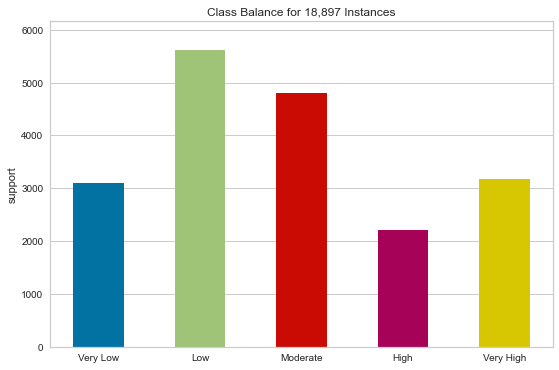

<AxesSubplot:title={'center':'Class Balance for 18,897 Instances'}, ylabel='support'>

In [26]:
#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=['Very Low','Low','Moderate','High','Very High'])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [29]:
from sklearn.utils import resample
seed = 123


#Separate majority and minority classes
vlow = est[est["Child Opportunity Levels, education domain, nationally- normed"]=='Very Low']
low = est[est["Child Opportunity Levels, education domain, nationally- normed"]=='Low']
mod = est[est["Child Opportunity Levels, education domain, nationally- normed"]=='Moderate']
high = est[est["Child Opportunity Levels, education domain, nationally- normed"]=='High']
vhigh = est[est["Child Opportunity Levels, education domain, nationally- normed"]=='Very High']

# Downsample majority class
vlow_downsampled = resample(vlow, 
                                replace=False, # sample without replacement
                                n_samples=len(vhigh), # to match minority class
                                random_state=seed) # reproducible results
low_downsampled = resample(low, 
                                replace=False, # sample without replacement
                                n_samples=len(vhigh), # to match minority class
                                random_state=seed) # reproducible results
mod_downsampled = resample(mod, 
                                replace=False, # sample without replacement
                                n_samples=len(vhigh), # to match minority class
                                random_state=seed) # reproducible results
high_downsampled = resample(high, 
                                replace=False, # sample without replacement
                                n_samples=len(vhigh), # to match minority class
                                random_state=seed) # reproducible results
# Combine minority class with downsampled majority class
df = pd.concat([vlow_downsampled,low_downsampled,mod_downsampled,high_downsampled, vhigh])

# Display new class counts
df['Child Opportunity Levels, education domain, nationally- normed'].value_counts()

Very Low     2211
Moderate     2211
Low          2211
Very High    2211
High         2211
Name: Child Opportunity Levels, education domain, nationally- normed, dtype: int64

In [30]:
X = df.iloc[:,:-8]
y = df["Child Opportunity Levels, education domain, nationally- normed"]

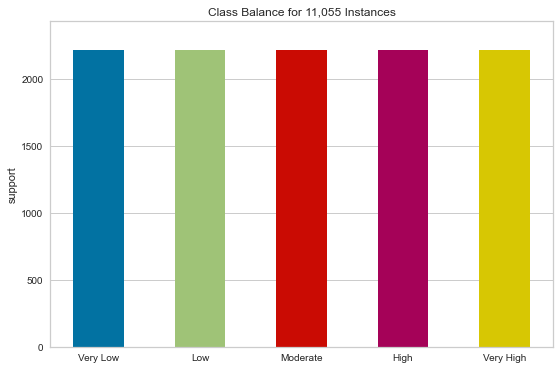

<AxesSubplot:title={'center':'Class Balance for 11,055 Instances'}, ylabel='support'>

In [31]:
#from yellowbrick.datasets import load_game
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=['Very Low','Low','Moderate','High','Very High'])

visualizer.fit(y)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [32]:
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8844, 137) (8844,)
(2211, 137) (2211,)


In [36]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)


models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [39]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['Very Low','Low','Moderate','High','Very High'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(X, y)
    visualizer.score(X, y)
    visualizer.show()

F1 SCORE SVC: 0.6566259611035731


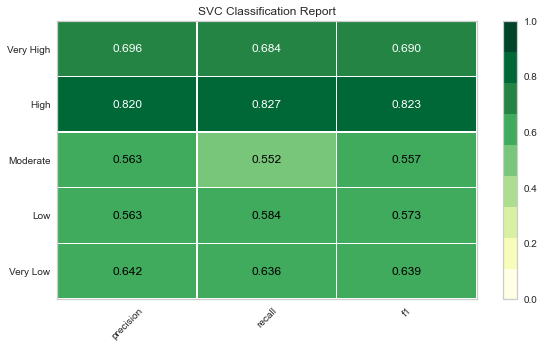

F1 SCORE NuSVC: 0.6960651289009498


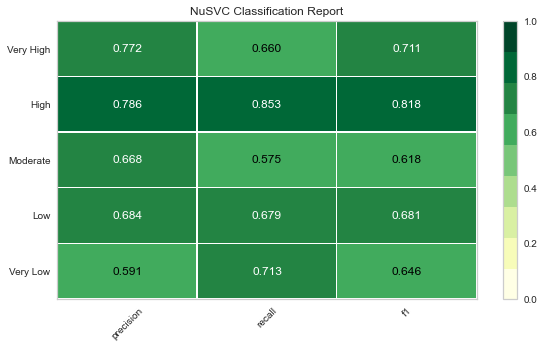

F1 SCORE LinearSVC: 0.46512890094979653


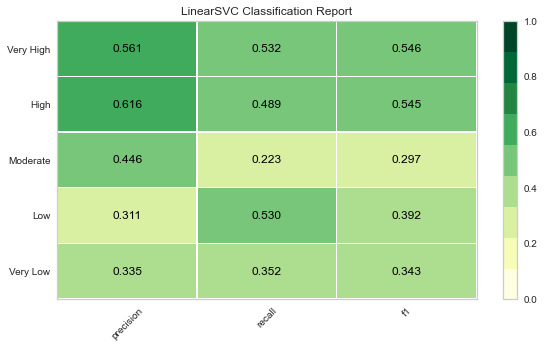

F1 SCORE SGDClassifier: 0.19529624604251467


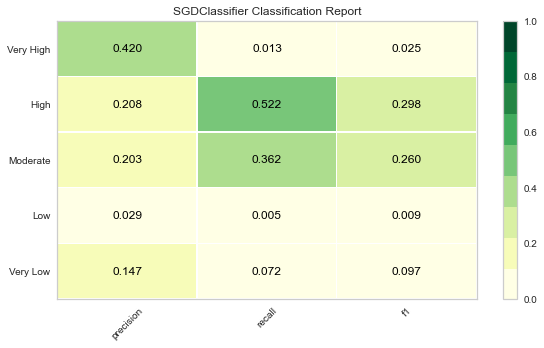

F1 SCORE KNeighborsClassifier: 0.6453188602442333


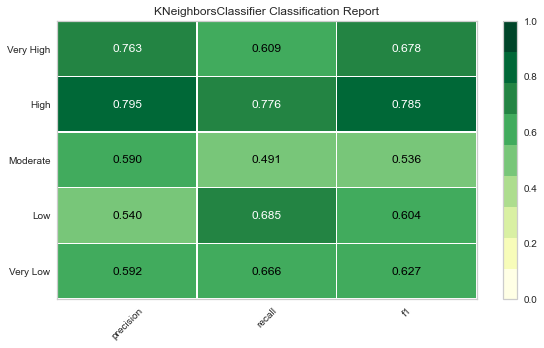

F1 SCORE LogisticRegression: 0.2996834011759385


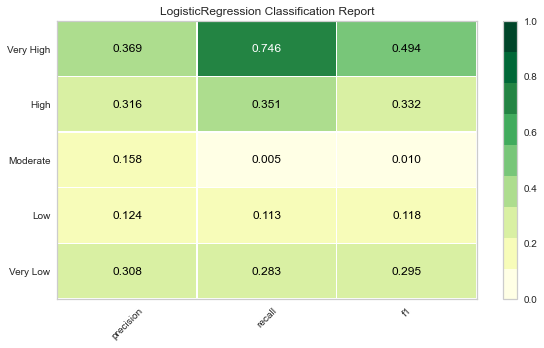

F1 SCORE LogisticRegressionCV: 0.3179556761646314


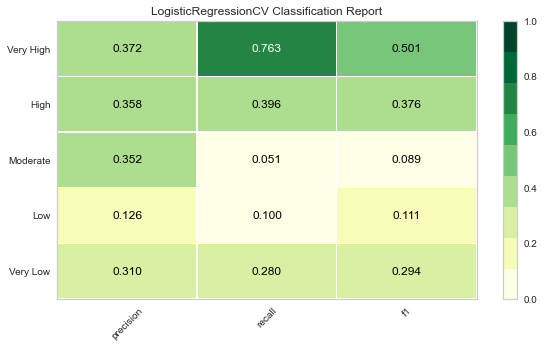

F1 SCORE BaggingClassifier: 0.9882406151062868


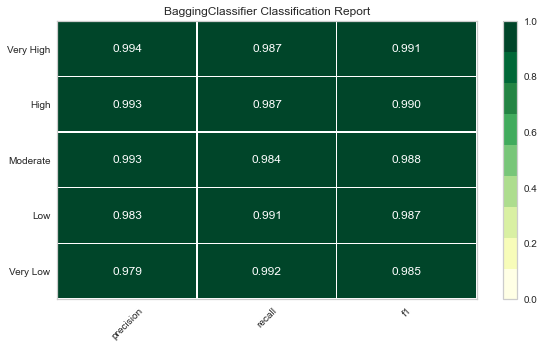

F1 SCORE ExtraTreesClassifier: 0.9999095431931253


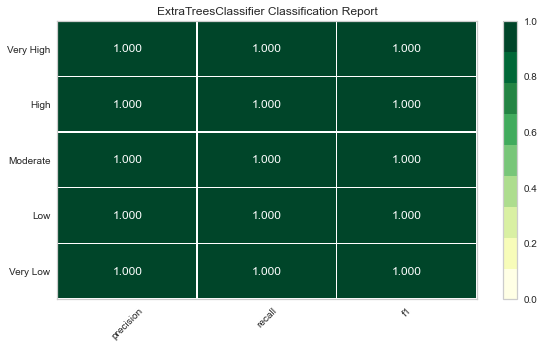

F1 SCORE RandomForestClassifier: 0.9999095431931253


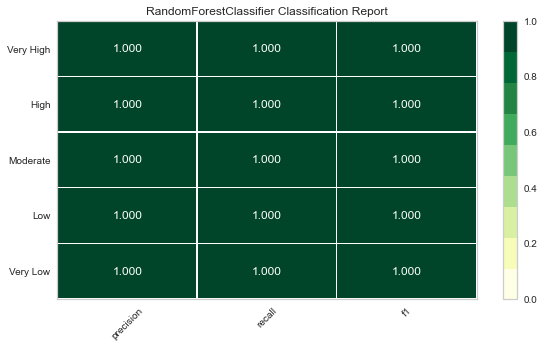

In [40]:
for model in models:
    score_model(X, y, model)
    visualize_model(X, y, model)